# __BIC (Bayesian Information Criteria) plot__

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr), Cécile Cabanes (cecile.cabanes@ifremer.fr) and Guillaume Maze (gmaze@ifremer.fr)
***

## Description

**The objective of this notebook is calculate and plot the BIC (Bayesian Information Criteria) to help you to find the optimal number of classes for your dataset.**

The BIC ([Bayesian Information Criteria](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) can be used to __optimize the number of classes__ in the PCM model, trying not to over-fit or under-fit the data. To compute this index, the model is fitted to the training dataset for a range of K values from 0 to 20. A __minimum__ in the BIC curve will give you the optimal number of classes to be used.

This notebook is a complement of the classification notebook *Classif_ArgoReferenceDatabase.ipynb*.

***
This notebook has been developed at the Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Euro-ArgoRISE project. This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: Individual support to ESFRI and other world-class research infrastructures.

<div>
<center>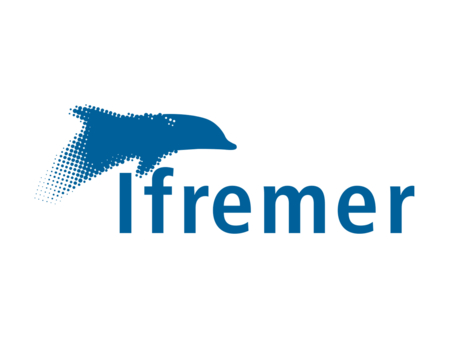 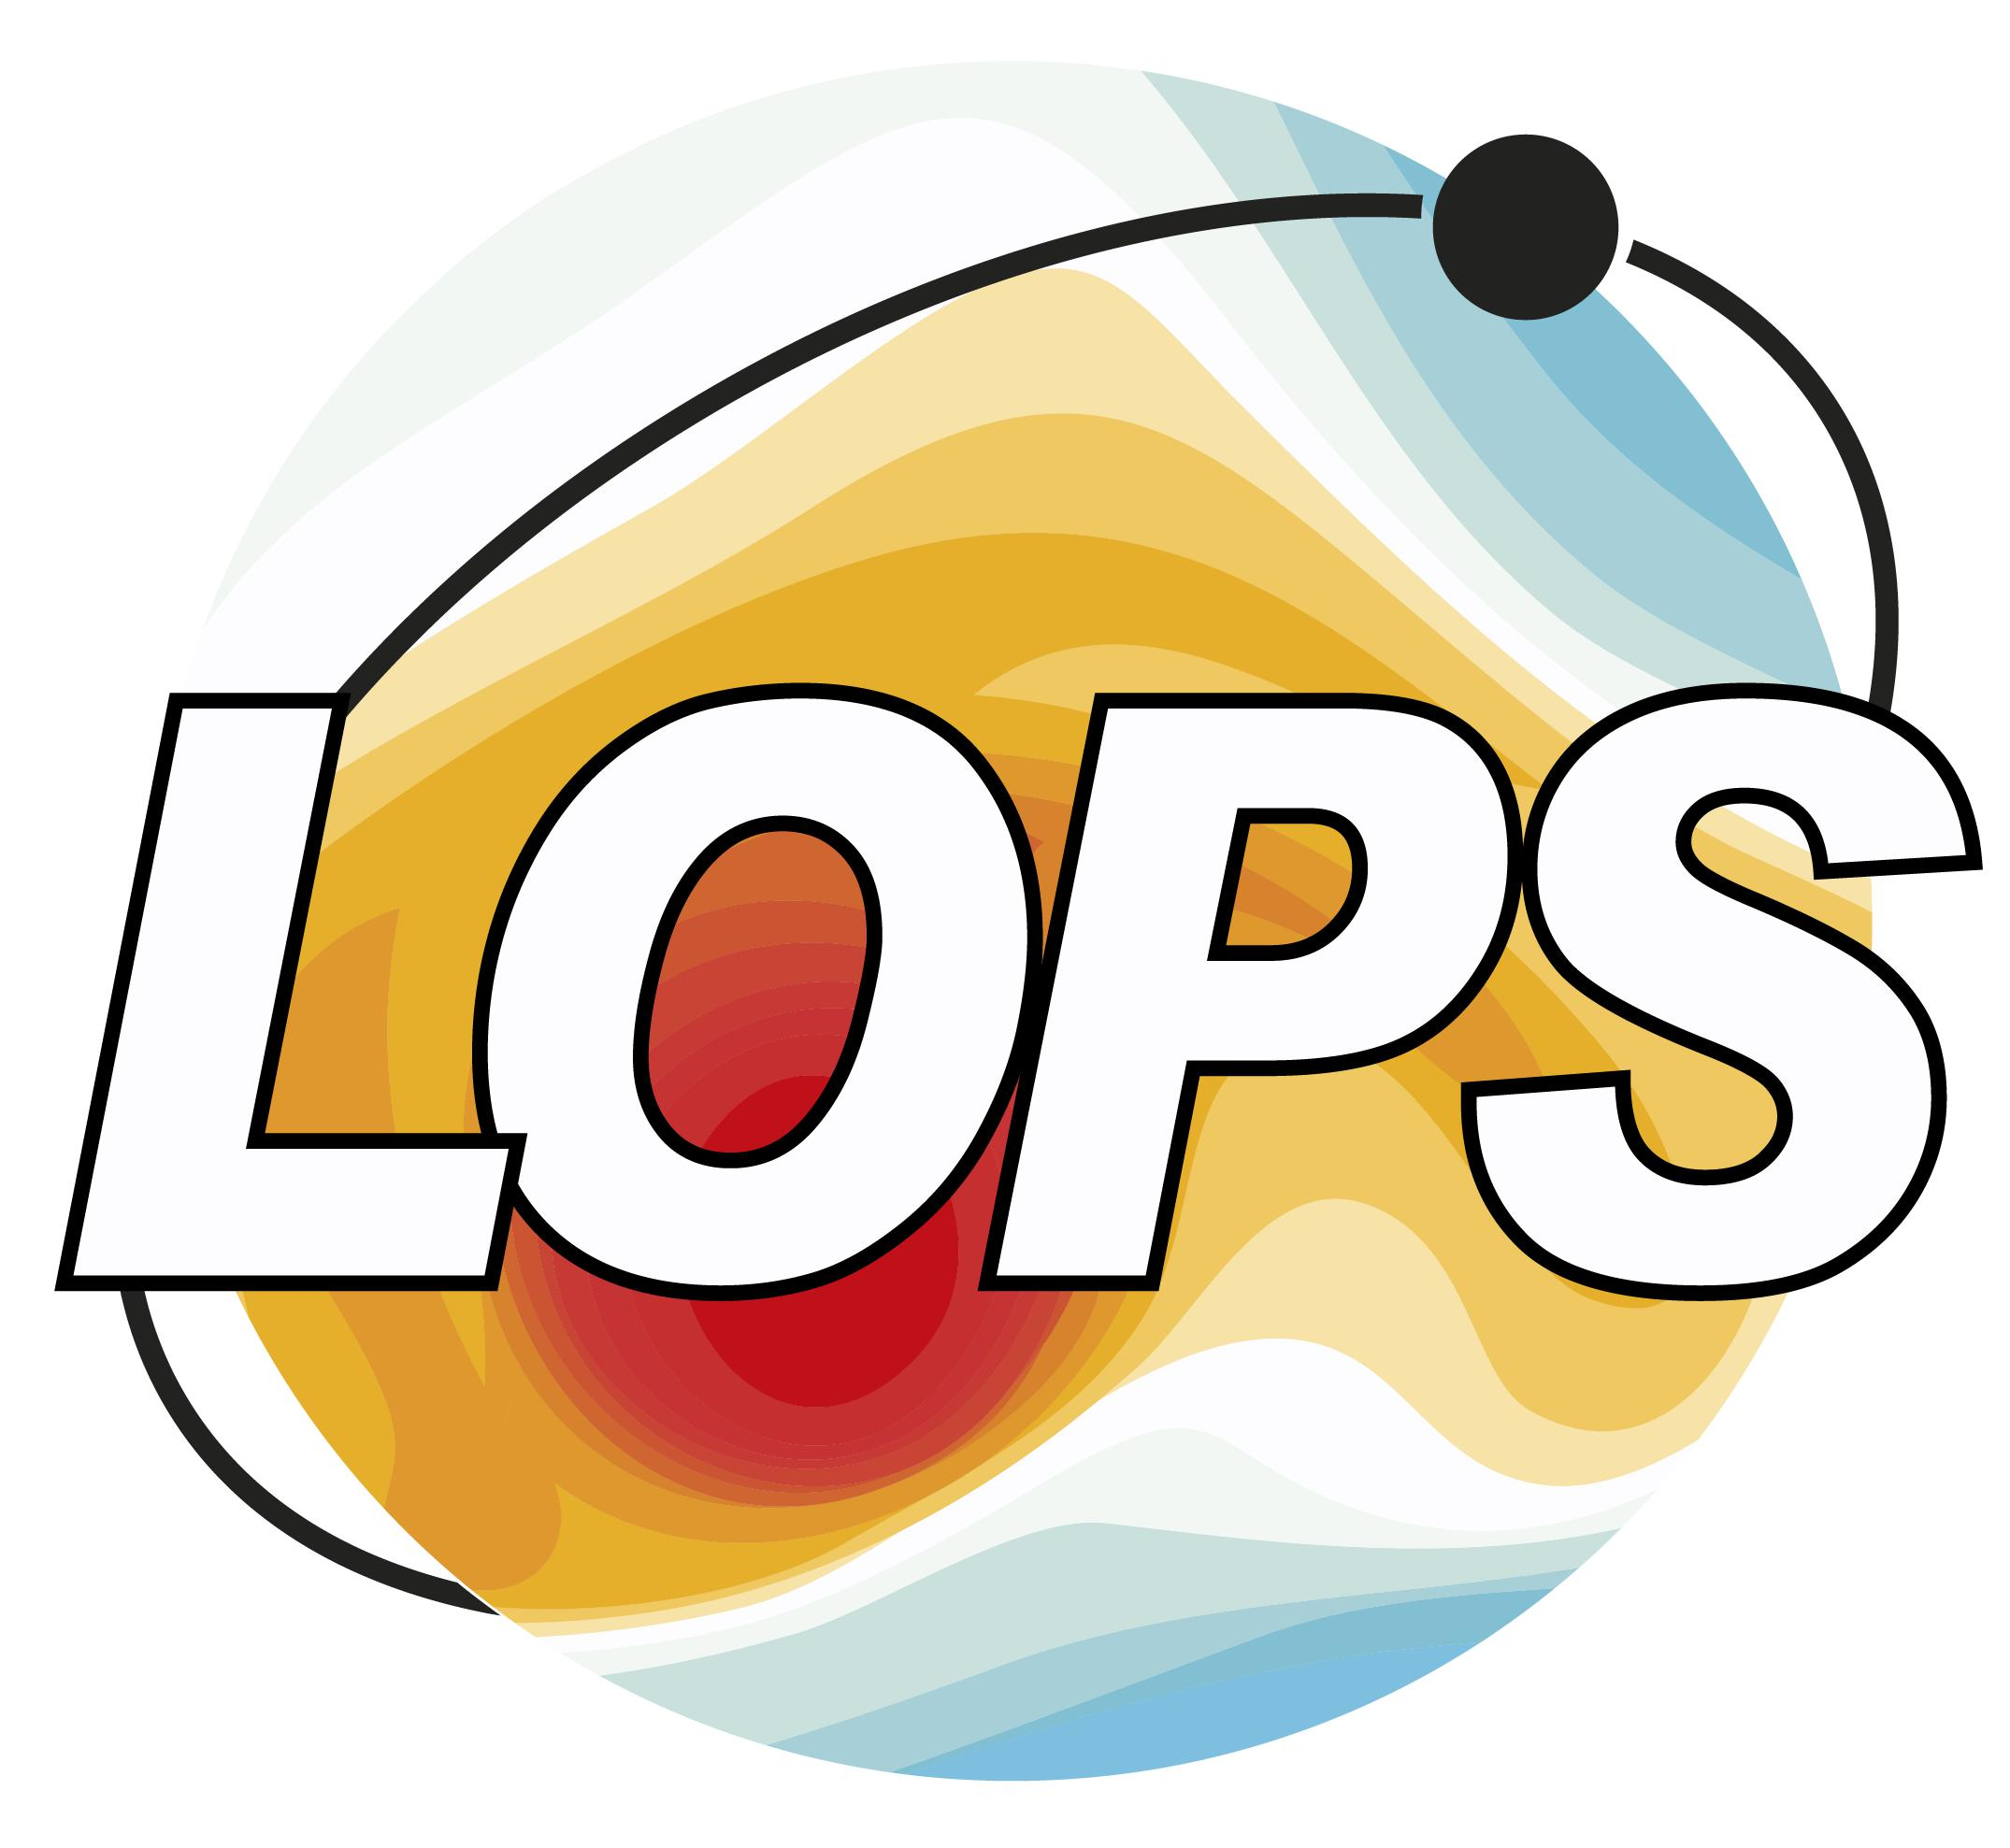 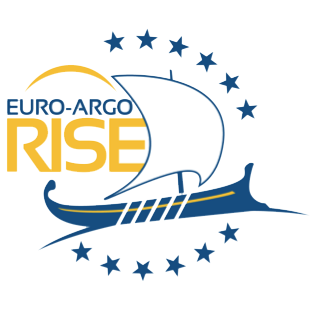</center>
</div>

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

from BIC_calculation import *

from classif_functions import *
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import sys
np.set_printoptions(threshold=sys.maxsize)

import configparser

## User inputs
***

__Configuration file__

You should provide the path to the **OWC configuration file** (*ow_config.txt*). The information used to select the profiles from the Argo reference database came from this file (``MAPSCALE_LONGITUDE_LARGE`` and ``MAPSCALE_LATITUDE_LARGE``). You can find the most suitable OWC configuration parameters for you float in the DMQC cookbook ([*Cabanes et al, 2021*](https://archimer.ifremer.fr/doc/00678/78994/)). The paths to the Argo reference database directory and the float data are read in the *ow_config.txt* file as well.

In [2]:
config_filename = '/home6/homedir10/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

__Interpolation depth__

The PCM can not deal with NaN values, so the reference dataset is interpolated on standard depth levels and the profiles shallower than the **max_depth**, defined below, are dropped out. A max depth of 1000m can be enough, however you should find a compromise between keeping a sufficient number of reference profiles and having a comprehensive representation of the oceanography in the region. You should also consider the depth of the float profiles: if they are shallower than the max depth, they will be dropped out, and they will not be classified by the PCM. In such cases, a lower value of max depth is recommended.

In [3]:
max_depth = 1000

__Float reference number__

You should provide the **WMO number** of the float you want to correct in OWC. We propose to you 3 examples (explained in the deliverable, link), float 4900136 crossing the Gulf Stream, float 3901928 in the Southern Ocean and float 3901915 in the Agulhas Current. We encourage you to try your own floats!

In [4]:
# Gulf Stream 
float_WMO = 4900136
# Southern ocean
#float_WMO = 3901928
# Agulhas Current
#float_WMO = 3901915
# Galicia
#float_WMO = 6900230

## Load argo reference database
***

Important paths are read in the OWC configuration file and data is loaded from the Argo reference database.

__Read OWC configuration file__

In [5]:
with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

Three paths are automatically assigned from the OW configuration file:

- ***wmo_boxes_argo.mat*** file path, to determine if you use Argo data, CTD data or both as reference dataset (as in OWC, see [DMQC cookbook](https://archimer.ifremer.fr/doc/00678/78994/))
- path to the **Argo reference database**
- float source directory, where we will find the *.mat* file containing the **float data**. If you have not created the .mat file yet, you can generate it using the last version of argopy (link to argopy and exemple of function).

You can change the automatic paths below, if needed.

In [6]:
wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
ref_path = config['historical_directory']
float_mat_path = config['float_source_directory'] + str(float_WMO)+ '.mat'

__Load argo reference database__

Data is selected in the same way as OWC does: **ellipses** using the longitude and latitude scales defined in the OWC configuration file are constructed around each float profile. The ``map_pv_use`` option makes the selection taking into account the bathymetrie.

In [7]:
ds = get_refdata(float_mat_path = float_mat_path, 
                 WMOboxes_latlon = 'WMO_boxes_latlon.txt', 
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7307.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7207.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7506.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7406.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7306.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7206.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7505.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7405.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7305.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7205.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7504.mat
/home5/pharos/argo/DMARGO/OW/VER

In [8]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 1049, n_profiles: 8793)
Coordinates:
    long        (n_profiles) float64 289.5 289.9 288.9 ... 310.1 313.2 314.1
    lat         (n_profiles) float64 37.31 35.62 37.9 ... 39.79 39.49 39.72
    dates       (n_profiles) datetime64[ns] 2012-01-26T10:51:49 ... 2015-08-1...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 8787 8788 8789 8790 8791 8792
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.0 5.0 5.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 20.84 19.48 27.21 ... nan nan nan
    sal         (n_pres, n_profiles) float64 36.49 36.53 34.38 ... nan nan nan
    source      (n_profiles) <U46 '1901465_029.BRECKOWENS' ... '4901755_081.B...
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


__Interpolate to standard levels (apres!!!!!)__

The dataset `ds` is interpolated on standard depth levels and the profiles shallower than the **max_depth** are dropped out.

In [9]:
ds = interpolate_standard_levels(ds, std_lev=np.arange(0,max_depth))

/home6/homedir10/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:137: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [10]:
print(ds)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 8241)
Coordinates:
    long               (n_profiles) float64 289.5 289.9 288.9 ... 313.2 314.1
    lat                (n_profiles) float64 37.31 35.62 37.9 ... 39.49 39.72
    dates              (n_profiles) datetime64[ns] 2012-01-26T10:51:49 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 8788 8789 8790 8791 8792
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 36.49 ... 34.96
    source             (n_profiles) object '1901465_029.BRECKOWENS' ... '4901...
    temp               (n_profiles, PRES_INTERPOLATED) float64 20.84 ... 4.956
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


Quick plot of the profiles in `ds`.

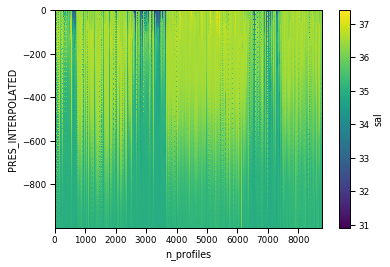

In [11]:
ds['sal'].plot(x='n_profiles');

Plot of the **spatial distribution** of the reference dataset `ds`.

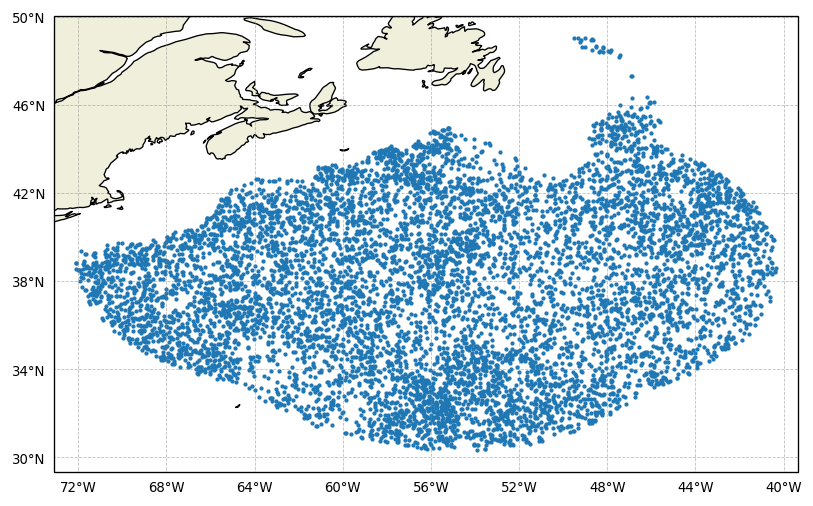

In [12]:
plot_spatialdist_ds(ds, float_WMO, float_traj=False)

## BIC plot
***

The BIC ([Bayesian Information Criteria](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) can be used to __optimize the number of classes__ in the model, trying not to over-fit or under-fit the data. To compute this index, the model is fitted to the training dataset for a range of K values from 0 to 20. A __minimum__ in the BIC curve will give you the optimal number of classes to be used.

Moreover, for each K range run, a subset of the training dataset is randomly selected in order to use *independent* profiles. Indeed, the ocean exhibits spatial correlations that reduce the real information contained in the training dataset. This has to be taken into account. This turns to our advantage here because the grid of the dataset allows to draw several subsets of uncorrelated profiles, finally allowing us to compute several times each K range run and hence to compute a standard deviation on the BIC metric.

The spatial correlation scale to consider is determined by the user. 
You should also choose a training set with limited correlation in time. 
Values in the cell below are ok for the Mediterranean sea example shown here.
If you want to try another geographical selection or another variable you may change these numbers.

You can also choose the number of runs and the maximum number of classes, taking into account that increasing this numbers will increase the computation time. 

__User input__

In [13]:
corr_dist = 50 # correlation distance in km
time_steps = ['2018-01','2018-07']  # time steps to be used into account
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

__BIC calculation__

Calculation is parallelized but this can take a few minutes to run

In [14]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
#z = ds[z_dim]
z = np.arange(0,max_depth)
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

In [15]:
def BIC_cal(X, k, pcm_features):
    ''' Function that calculates BIC for a number of classes k

            Parameters
            ----------
                X: dataset after preprocessing
                k: number of classes

            Returns
            ------
                BIC: BIC value
                k: number of classes

           '''

    # create model
    m = pcm(K=k + 1, features=pcm_features)
    # fit model
    m._classifier.fit(X)

    # calculate LOG LIKEHOOD
    llh = m._classifier.score(X)

    # calculate Nb of independant parameters to estimate
    # we suppose m._classifier.covariance_type == 'full'
    _, n_features = m._classifier.means_.shape
    cov_params = m._classifier.n_components * \
                 n_features * (n_features + 1) / 2.
    mean_params = n_features * m._classifier.n_components
    Nf = int(cov_params + mean_params + m._classifier.n_components - 1)

    # calculate bic
    N_samples = X.shape[0]
    BIC = (-2 * llh * N_samples + Nf * np.log(N_samples))
    # BIC = m._classifier.bic(X)

    return BIC, k

In [16]:
def mapping_corr_dist(corr_dist, start_point, grid_extent):
    '''Remapping longitude/latitude grid using a start point. It creates a new grid from the start point 
       where each point is separated the given correlation distance.

           Parameters
           ----------
               corr_dist: correlation distance
               start_point: latitude and longitude of the start point 
               grid_extent: max and min latitude and longitude of the grid to be remapped 
                    [min lon, max lon, min let, max lat]

           Returns
           ------
               new_lats: new latitude vector with points separeted the correlation distance 
               new_lons: new longitude vector with points separeted the correlation distance

               '''

    # angular distance d/earth's radius (km)
    delta = corr_dist / 6371

    # all in radians (conversion at the end)
    grid_extent = grid_extent * np.pi / 180
    start_point = start_point * np.pi / 180

    ### while loop for lat nord ###
    max_lat = grid_extent[3]
    lat2 = -np.pi / 2
    lat1 = start_point[1]
    # bearing = 0 donc cos(0)=1 and sin(0)=0
    new_lats = [lat1]
    while lat2 < max_lat:
        lat2 = np.arcsin(np.sin(lat1) * np.cos(delta) +
                         np.cos(lat1) * np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2

    ### while loop for lat sud ###
    min_lat = grid_extent[2]
    lat2 = np.pi / 2
    lat1 = start_point[1]
    # bearing = pi donc cos(pi)=-1 and sin(pi)=0
    while lat2 > min_lat:
        lat2 = np.arcsin(np.sin(lat1) * np.cos(delta) -
                         np.cos(lat1) * np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2

    new_lats = np.sort(new_lats) * 180 / np.pi

    ### while loop for lon east ###
    max_lon = grid_extent[1]
    lon2 = -np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = pi/2 donc cos(pi/2)=0 and sin(pi/2)=1
    new_lons = [lon1]
    dlon = np.arctan2(np.sin(delta) * np.cos(lat1),
                      np.cos(delta) - np.sin(lat1) * np.sin(lat1))
    while lon2 < max_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2

    ### while loop for lon west ###
    min_lon = grid_extent[0]
    lon2 = np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = -pi/2 donc cos(-pi/2)=0 and sin(-pi/2)=-1
    dlon = np.arctan2(-np.sin(delta) * np.cos(lat1),
                      np.cos(delta) - np.sin(lat1) * np.sin(lat1))
    while lon2 > min_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2

    new_lons = np.sort(new_lons) * 180 / np.pi

    return new_lats, new_lons

In [19]:
def BIC_calculation(ds, corr_dist, coords_dict, pcm_features, features_in_ds, z_dim, Nrun=10, NK=20):
    '''Calculation of BIC (Bayesian Information Criteria) for a training dataset.
        The calculation is parallelised using ThreadPoolExecutor.

           Parameters
           ----------
               ds: dataset
               corr_dist: correlation distance
               coords_dict: dictionary with coordinates names
                    {'depth': 'depth', 'latitude': 'latitude', 'time': 'time', 'longitude': 'longitude'}
               pcm_features: dictionary with pcm features {'temperature': z vector}
               features_in_ds: dictionary with the name of feaures in the model and in the dataste
                    {temperature: thetao} 
               z_dim: name of the z variable
               Nrun: number of runs
               NK: max number of classes

           Returns
           ------
               BIC: matrix with BIC value for each run and number of classes
               BIC_min: minimun BIC value calculated from the mean of each number of classes

               '''

    # TODO: latitude and longitude values
    # TODO: automatic detection of variables names
    # TODO: If only one time step?

    # grid extent
    grid_extent = np.array([ds[coords_dict.get('longitude')].values.min(), ds[coords_dict.get('longitude')].values.max(
    ), ds[coords_dict.get('latitude')].values.min(), ds[coords_dict.get('latitude')].values.max()])

    # this is the list of arguments to iterate over, for instance nb of classes for a PCM
    class_list = np.arange(0, NK)

    ## Here was the previously nested BIC_cal function

    BIC = np.zeros((NK, Nrun))
    for run in range(Nrun):

        for itime in range(len(time_steps)):  # time loop
            # random fist point
            latp = np.random.choice(ds[coords_dict.get('latitude')].values, 1, replace=False)
            lonp = np.random.choice(ds[coords_dict.get('longitude')].values, 1, replace=False)
            # remapping
            new_lats, new_lons = mapping_corr_dist(
                corr_dist=corr_dist, start_point=np.concatenate((lonp, latp)), grid_extent=grid_extent)

            #ds.sel({coords_dict.get('latitude'): 30, coords_dict.get('longitude'): 30}, method='nearest')
            ds_run_i = ds.sel({coords_dict.get('latitude'): list(new_lats), coords_dict.get('longitude'): list(new_lons)}, method='nearest')
            ds_run_i = ds_run_i.sel({coords_dict.get('time'): time_steps[itime]})

            # change lat and lot dimensions by index to be able to merge the datasets (it is not necessary to have lat lon information)
            n_lati = ds_run_i[coords_dict.get('latitude')].size
            n_loni = ds_run_i[coords_dict.get('longitude')].size
            # concat results
            if itime == 0:
                # change lat and lon to index
                ds_run_i[coords_dict.get('latitude')] = np.arange(0, n_lati)
                ds_run_i[coords_dict.get('longitude')] = np.arange(0, n_loni)
                n_lat = n_lati
                n_lon = n_loni
                ds_run = ds_run_i
            else:
                # change lat and lon to index
                ds_run_i[coords_dict.get('latitude')] = np.arange(n_lat, n_lat + n_lati)
                ds_run_i[coords_dict.get('longitude')] = np.arange(n_lon, n_lon + n_loni)
                n_lat = n_lat + n_lati
                n_lon = n_lon + n_loni
                # concat time steps
                ds_run = xr.concat([ds_run, ds_run_i], dim=coords_dict.get('time'))

        # pre-processing
        # K=4 it is not important, it is only used for preprocess data
        m = pcm(K=4, features=pcm_features)
        X, sampling_dims = m.preprocessing(
            ds_run, features=features_in_ds, dim=z_dim, action='fit')

        # serial computation of BIC
        results = []
        for k in class_list:
            results.append(BIC_cal(X, k, pcm_features))

        results = [r for r in results if r is not None]
        results.sort(key=lambda x: x[1])
        BIC[:, run] = np.array([i[0] for i in results])

    BIC_min = np.argmin(np.mean(BIC, axis=1)) + 1

    return BIC, BIC_min

In [20]:
[BIC, BIC_min] = BIC_calculation(ds=ds, 
                                 corr_dist=corr_dist,
                                 coords_dict={'depth': 'PRES_INTERPOLATED', 'latitude': 'lat', 'longitude': 'long'},
                                 pcm_features=pcm_features,
                                 features_in_ds=features_in_ds,
                                 z_dim=z_dim,
                                 Nrun=Nrun,
                                 NK=NK)

ValueError: dimensions or multi-index levels ['lat', 'long'] do not exist

In [ ]:
%%time
ds_run = get_regulargrid_dataset(ds, corr_dist, season=['all'])

In [ ]:
proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_run['long'], ds_run['lat'], s=3, transform=proj, label='Argo reference data')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

BIC calculation

In [ ]:
%%time

# create distance matrix
#dist_matrix = cal_dist_matrix(ds['lat'].values, ds['long'].values)

BIC = np.zeros((NK-1, Nrun))

for run in range(Nrun):
    print(run)
    # get sub-sampling dataset
    print('subsampling ...')
    ds_run = get_regulargrid_dataset(ds, corr_dist)
    ds_run = interpolate_standard_levels(ds_run, std_lev=np.arange(0,max_depth))
    print(ds_run)
    print(np.sum(np.isnan(ds_run['PRES_INTERPOLATED'])))
    
    # pre-processing
    # K=4 it is not important, it is only used for preprocess data
    print('preprocesing ...')
    print(pcm_features)
    print(features_in_ds)
    print(z_dim)
    m = pcm(K=4, features=pcm_features)
    X, sampling_dims = m.preprocessing(ds_run, features=features_in_ds, dim=z_dim, action='fit')
    
    print('bic calculation ...')
    BICi=[]
    for k in range(1,NK):
        print(k)
        print(BIC_cal(X, k, pcm_features)[0])
        BICi.append(BIC_cal(X, k, pcm_features)[0])
        
    BIC[:, run] = np.array([i for i in BICi])
    print(BIC)
    
BICmean = np.mean(BIC, axis=1)
BICstd = np.std(BIC, axis=1)

__BIC plot__

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k')
ax.plot(np.arange(NK-1) + 1, BICmean, label='BIC mean')
ax.plot(np.arange(NK-1) + 1, BICmean + BICstd,
             color=[0.7] * 3, linewidth=0.5, label='BIC std')
ax.plot(np.arange(NK-1) + 1, BICmean - BICstd, color=[0.7] * 3, linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of classes')
plt.xticks(np.arange(NK) + 1)
plt.title('Bayesian information criteria (BIC)')

print('BIC min: ' + str(np.argmin(BICmean) + 1))

__Optimized number of classes__

In [ ]:
BIC_min

If this is not the number of classes you chose in the beginning of the notebook, don't worry, you will fit your model again with the appropriate number of classes at the end of the notebook.

The BIC curve may not show a clear minimum. This can be an indication that some profiles remained correlated in the training set, so try to adjust more precisely the correlation scale.

If the BIC curve has a clear minimum, don't forget to take into account the standard deviation. The BIC curve indicates a statistical optimum, so if the minimum is not above the standard deviation range, then it is indicative of an optimal **range** rather than a precise value. In this case, use your expertise to choose the number of classes (within the BIC allowed range) leading to ocean patterns that simply make the most sense to you.